In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Pandas version:  2.2.2
Numpy version:  1.26.4
Scikit-learn version:  1.5.2


In [ ]:
df= pd.read_csv("/content/Drexel_fatigue.csv")


In [ ]:
df

,hits,cycles,RUL,RUL_norm
0,163,0,568,1.000000
1,132,1,567,0.998239
2,109,2,566,0.996479
3,97,3,565,0.994718
4,97,4,564,0.992958
...,...,...,...,...
1811,406,622,4,0.006390
1812,385,623,3,0.004792
1813,286,624,2,0.003195
1814,682,625,1,0.001597


In [ ]:
train_data=df.iloc[:1187,:]

In [ ]:
test_data=df.iloc[1187:,:]

In [ ]:
test_data.shape

(629, 4)

### How many engines are there?

Number of unique values in first column gives us the total number of specimens that are under study in this dataset.

In [ ]:
np.unique(train_data['specimen'])

array([1, 2, 3])

after how many cycle does the specimens fail

In [ ]:
num_cycles_to_failure = train_data.groupby('specimen')['label'].max()
num_cycles_to_failure.values

array([3113, 1257, 2191])

In [ ]:
x=max(train_data['label'].where(train_data['specimen']==1))

In [ ]:
x

3113.0

In [ ]:
engine_1_linear_degradation_model = np.arange(3113-1, -1, -1)

# Piecewise_linear_degradation model
early_rul = 1000
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape = (3113-early_rul,)),
                                                        np.arange(early_rul-1, -1, -1))

print("Linear degradation model shape (for engine 1): ", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model shape (for engine 1): ", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model shape (for engine 1):  (3113,)
Piecewise linear degradation model shape (for engine 1):  (3113,)


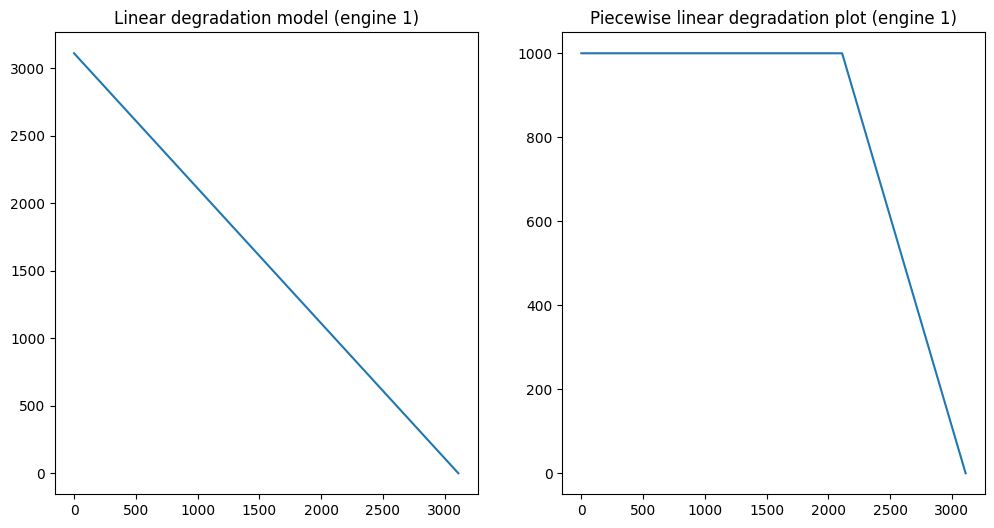

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_1_linear_degradation_model)
plt.title("Linear degradation model (engine 1)")
plt.subplot(122)
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise linear degradation plot (engine 1)")
plt.show()

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength (i.e., total number of cycles for each engine) and early_rul as input and
    creates target rul.

    Arguments:
        data_length: (scaler) Number of cycles for each engine
        early_rul: (scaler) Early RUL value to be set. When set to `None`, linear degradation
                   curve is used. (deafult: None)

    Returns:
        target_array: (1D float array) Target array
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:    # This condition is needed when early rul is larger than data_length of an engine
            target_array = np.arange(data_length-1, -1, -1)
            return target_array
        else:
            target_array = np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return target_array

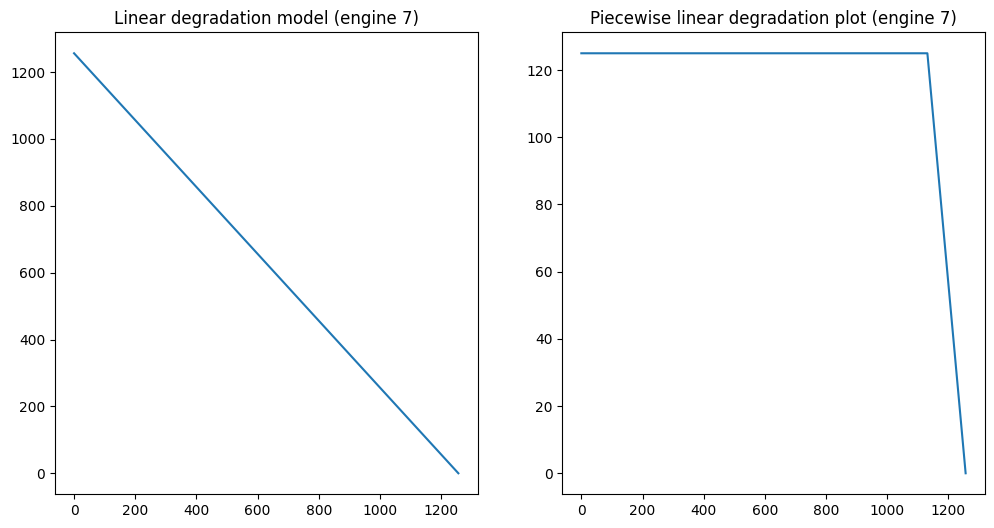

In [ ]:
engine_7_linear_degradation_rul = process_targets( 1257, early_rul = None)
engine_7_piecewise_linear_degradation_rul = process_targets( 1257, early_rul = 125)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_7_linear_degradation_rul)
plt.title("Linear degradation model (engine 7)")
plt.subplot(122)
plt.plot(engine_7_piecewise_linear_degradation_rul)
plt.title("Piecewise linear degradation plot (engine 7)")
plt.show()

## Analyzing Test data

Test data are similar to train data with only one difference. While for training data, data are available until failure for each specimen, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

In [ ]:
test_data = pd.read_excel("/content/full2_test.xlsx")
test_data.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/full2_test.xlsx'

In [ ]:
test_data1 = pd.read_excel("/content/full2_test_1.xlsx")
test_data1.shape

(28411, 8)

In [ ]:
test_data1.tail()

,amplitude,duration,energy,rms,rise_time,counts,label,specimen
28406,71,25780,214563.400000,0.1086,15043,8699,0,3
28407,33,133,2.374981,0.1086,107,12,0,3
28408,56,3713,1421.721000,0.1086,1790,781,0,3
28409,49,3104,326.433800,0.1086,236,494,0,3
28410,83,19686,999010.200000,0.1096,11299,5461,0,3


In [ ]:
num_cycles1 = test_data1['label'].max()
num_cycles1

1640

In [ ]:
test_data1.head()

,amplitude,duration,energy,rms,rise_time,counts,label,specimen
0,31,10,0.31384,0.0004,8,6,1640,1
1,45,34116,2964.57700,0.0012,9917,8741,1640,1
2,31,79,1.21030,0.0012,0,9,1640,1
3,36,17241,314.88980,0.0010,4671,1315,1640,1
4,32,1406,14.84777,0.0010,0,37,1640,1


### How many specimens are there in test set?

In [ ]:
np.unique(test_data1['specimen'])

array([1, 2, 3])

So there are 100 engines in test set also.

### How many cycles of data are available for each specimen in test set?

In [ ]:
num_cycles = test_data1.groupby('specimen')['label'].min()
num_cycles.values

array([761, 315,   0])

In [ ]:
test_data.groupby(0)[1].count().values

KeyError: 0

In [ ]:
true_rul=num_cycles.values
true_rul

array([761, 315,   0])

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

An RUL value of 112 for engine 1 in test set means that it failed 112 cycles after 31st cycle. So engine 1 ran for (31+112) cycles before it failed. Similarly engine two failed 98 cycles after 49th cycle. So engine 2 ran for (49 + 98) cycles in total before it failed. Similar calculation can be done for other engines in test set.

IndexError: single positional indexer is out-of-bounds

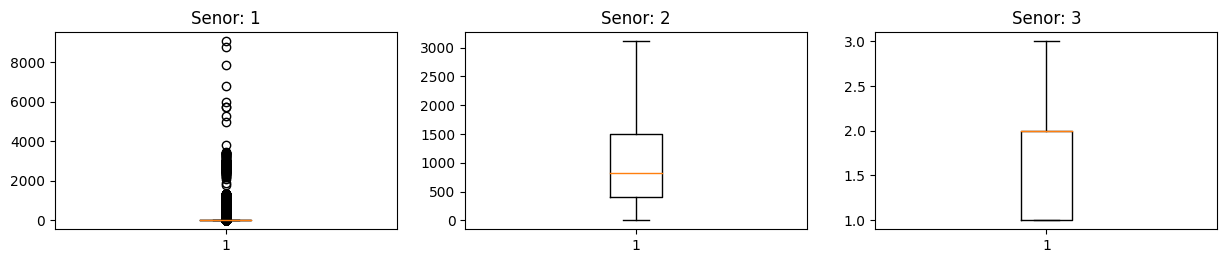

In [ ]:
plt.figure(figsize = (15, 21))
for i in np.arange(5, 26):        # column 5 in python means actual 6th column
    temp = train_data.iloc[:, i]
    plt.subplot(7,3, i-4)
    plt.boxplot(temp)
    plt.title("Senor: "+ str(i-4))
plt.show()

In [ ]:
train_data[10].value_counts()

21.61    20225
21.60      406
Name: 10, dtype: int64

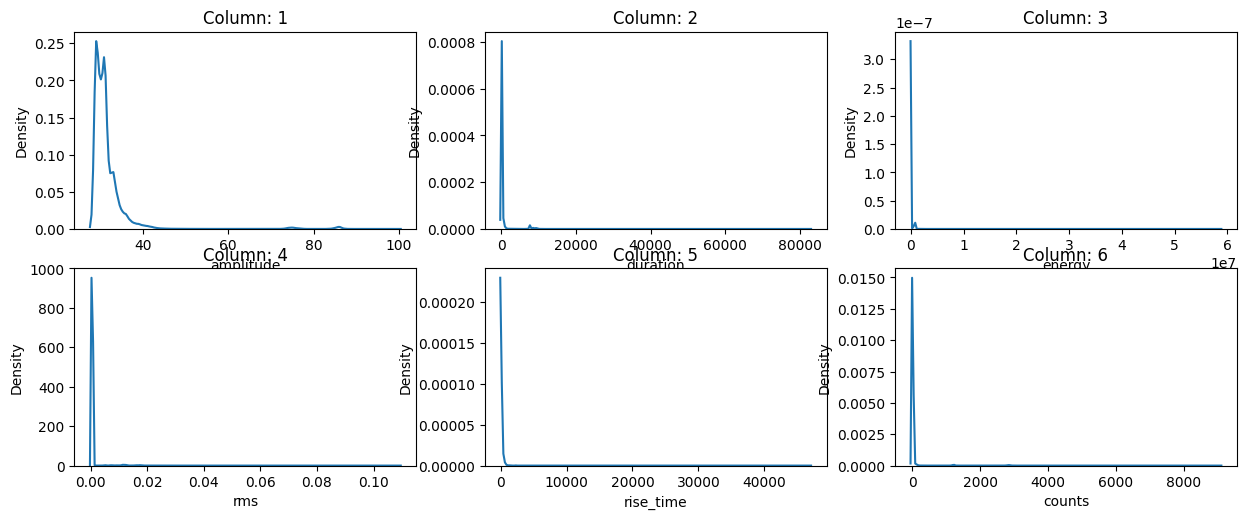

In [ ]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([0,1,2,3,4,5]):
    temp = train_data.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp, legend = False)
    plt.title("Column: "+ str(j+1))
plt.show()

An algorithm generalizes well (i.e., its performance on unseen data is good) if unseen data is similar in distribution to training data. Unseen data need not be exactly of same distribution as of training data but it should not be very different from training data.

Here, we will just check the distribution of training and test data. It should be noted that test data should never be used while training an algorithm. Training an algorithm is an iterative process. With more parameters, it is very likely that training error reduces nearly zero. But its performance on new unseen data is not that good. In that case, we say that the model has overfit the training data (or memorized the training examples). Therefore, while training we have to devise some way to check whether the model is learning something or just memorizing the training data. To do that, we extract a portion of training data as `validation set` and use the validation set to check performance of trained model at each iteration. Once we are satisfied with the final model, we can use it to evaluate its performance on test data. While iterating over different models, we should avoid overfitting the `validation data`.

Here, we will only show the density plot of training as well as test data.

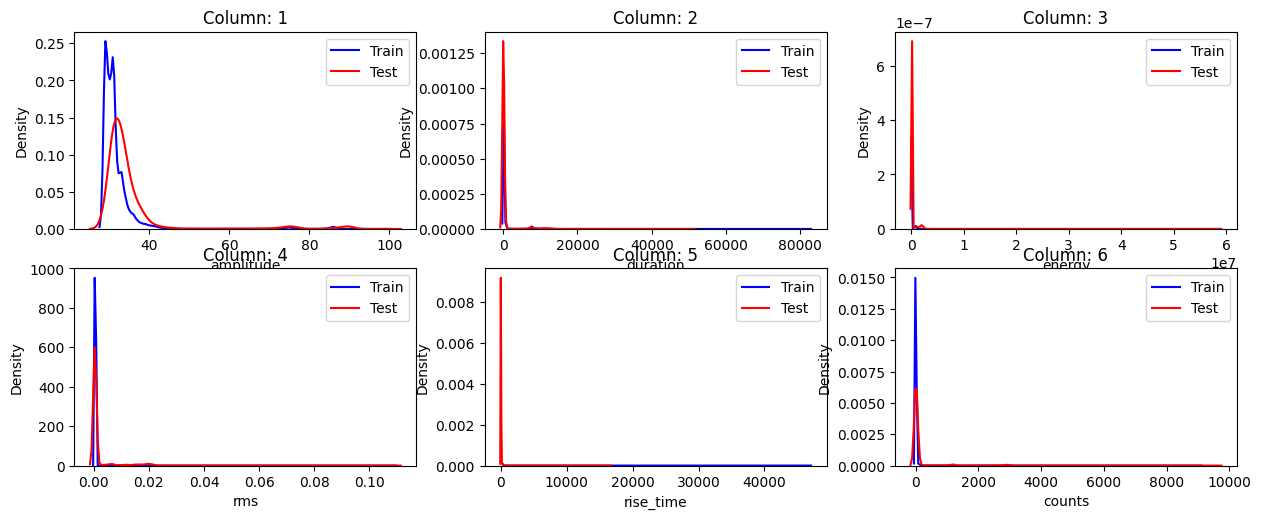

In [ ]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([0,1,2,3,4,5]):
    temp_train = train_data.iloc[:, j]
    temp_test = test_data1.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp_train, legend = False, color = "blue", label = "Train")
    sns.kdeplot(temp_test, legend = False, color = "red", label = "Test")
    plt.title("Column: "+ str(j+1))
    plt.legend()
plt.show()

Though not exact, test data has a similar distribution as training data. So if we design our algorithm carefully, it will generalize well.

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """
    Depending on values of window_length and shift, this function generates batchs of data and targets
    from `input_data` and `target_data`. `target_data` is optional. If no `target_data` is given, i.e.,
    `target_data = None`, no `output_targets` are generated. The following formula is used to determine
    number of batches. Please note that, here we use the term `batch` in a different sense than its usual
    meaning in deep learning.

    Number of batches = int(np.floor((len(input_data) - window_length)/shift)) + 1

    **We don't check input dimensions using exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: (Must be 2D array) input data to function
        target_data (optional): (Must be 1D array) Input rul values (default: None)
        window_length: (scalar) window length of data (default: 1)
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches (default: 1)

    Returns:
        output_data: (2D float array) Output data that would be passed to machine learning model
        output_targets (optional): (1D float array) Output targets. Only generated if `target_data` is
                                   passed as argument.
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In the above function, we have used an argument `shift`. It is closely related to number of overlap rows. For example, if window length is 30 and shift is 2, it would mean there is an overlap of 28 rows between successive data batches.

## Check whether the functions works as intended or not

In [ ]:
data = np.array([[1,2,3,4,5],
                 [6,7,8,9,10],
                 [11,12,13,14,15],
                 [16,17,18,19,20],
                 [21,22,23,24,25],
                 [26,27,28,29,30]])
ruls = np.array([31,32,33,34,35,36])
print("Data:")
print(data)
print()
print("RUL:")
print(ruls)

Data:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]]

RUL:
[31 32 33 34 35 36]


In [ ]:
check_data, check_rul = process_input_data_with_targets(data,target_data = ruls, window_length = 3, shift = 1)
print(check_data)
print()
print(check_rul)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]

 [[16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]
  [26. 27. 28. 29. 30.]]]

[33. 34. 35. 36.]


In [ ]:
check_data_2, check_rul_2 = process_input_data_with_targets(data,target_data = ruls, window_length = 3, shift = 2)
print(check_data_2)
print()
print(check_rul_2)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]]

[33. 35.]


Note that in our function, `target_data` argument is optional. If we don't pass any data in that argument, we get only batched data as output. This is useful for preprocessing test data for which we don't know target RUL values. The following cell illustrates this with an example.

In [ ]:
check_data_new = process_input_data_with_targets(data, target_data = None, window_length = 4, shift = 1)
check_data_new

array([[[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.]],

       [[ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25.]],

       [[11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25.],
        [26., 27., 28., 29., 30.]]])

Now we are ready to use the functions to preprocess the actual CMAPSS data. For this demonstration, we will use following function argument values.

* window_length = 30
* shift = 1 (It is equivalent to overlap of 29 rows between successive windowed data)
* early_rul = 125

We have also used

* MinMaxScaling with feature range (-1, 1). We can change this to StandardScaler if we want. Scaling is applied individually to each engine of training set. The scaling parameters learned from training data is then used to scale test data of corresponding engine.

### How to preprocess test data?

For each engine in the test set, we need to predict one RUL value. To predict one RUL value, we need one example of test data for each engine. So the obvious choice is to use the last example of test data for each engine. If an example consists of a window of data, for a given window length, we will take the last window of data that can be extracted from test set for a particular engine. For example, assume that for a particular engine, test set data has a shape of $(45 \times 14)$. For `window_length = 30`, and `shift = 1`, we can extract 16 windowed datasets of size $(30 \times 14)$. But we have to predict only one number as RUL for that engine. So, out of the 13 datasets of size $(30 \times 14)$, we will use the last one for predicting RUL.

The above approach, though technically correct, is prone to mistakes. What happens if the measurements of last example have some outliers? In that case our prediction would be way off. One approach to circumvent this issue is to take, say, last 5 examples instead of only the last example for each engine. Then we will get 5 RUL prediction values. We can average those to come up with our final estimate of RUL. In this way our RUL estimate will be a little conservative but robust against outliers in the last test example.

In the following cell, we will write a function that prepares a number of test examples as per user input.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examples we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler helps us do just that.

    Arguments:
        test_data_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)

    Returns:
        batched_test_data_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

Now we will check whether the above function works as intended or not.

In [ ]:
check_data = np.reshape(np.arange(24), newshape = (6,4))
check_data

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [ ]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 1)
print(last_examples)
print()
print(num_last_examples)

[[[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

1


Now change `num_test_window` to 3. This will extract last 3 examples.

In [ ]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 3)
print(last_examples)
print()
print(num_last_examples)

[[[ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[12. 13. 14. 15.]
  [16. 17. 18. 19.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

3


If we set `window_length = 1`, and `num_test_windows = 3`, we will simply select last 3 rows of test data. For the above toy data, we get the following result.

In [ ]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 1, shift = 1, num_test_windows= 3)
print(last_examples)
print()
print(num_last_examples)

[[[12. 13. 14. 15.]]

 [[16. 17. 18. 19.]]

 [[20. 21. 22. 23.]]]

3


### How to scale data?

For some algorithms, it is required to scale the data first before feeding it into the algorithm. We can use built-in scikit-learn scalers like `StandardScaler`, `MinMaxScaler`, etc. We will first scale the training data individually for each engine. Using the scaled parameters, we will then scale the data for corresponding test engine. For example, FD001 contains training data for 100 engines. So we will individually scale training data for 100 engines. Test data for FD001 also contains 100 engines. We will use scaling parameters of training data to scale corresponding engine data in test set.

When there is a discrepancy in number of engines between training and test set (this occurs in FD002 and FD004), we scale only those training data for which there is a corresponding engine in test set. Again to give a concrete example, FD004 contains 249 training engines but 248 test engines. So while scaling data for this case, we ignore data corresponding to engine 249 in training set as there is no corresponding data in test set.

In the following cell, scaling is performed using 3 lines of code. If for some application scaling is not required, then just comment those 3 lines.

In the following cell, we will preprocess both training and test data with scaling.

In [ ]:
window_length = 50
shift = 1
early_rul = None           # Set to None for linear degradation model
processed_train_data = []
processed_train_targets = []

# How many test examples to take for each engine. If set to 1 (this is the default), only last example of test data for
# each engine are taken. If set to a different number, that many examples from last are taken.
# Final output for an engine will be the average of output of all examples for that engine.
num_test_windows = 5    # Number of examples. Change to a different number to select that many test examples for each engine.
processed_test_data = []
num_test_windows_list = []  # This list keeps track of number of examples for all engines in the test set.

num_machines = np.min([len(train_data['specimen'].unique()), len(test_data1['specimen'].unique())])

for i in np.arange(1, num_machines+1):

    temp_train_data = train_data[train_data['specimen'] == i].drop(columns=['label','specimen']).values
    temp_test_data = test_data1[test_data1['specimen'] == i].drop(columns=['label','specimen']).values

    # Verify if data of given window length can be extracted from both training and test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # We have used MinMaxScaler. Use a different scaler if you want.
    # Or just comment the following 3 lines if no scaling is required.
    scaler = MinMaxScaler(feature_range = (-1, 1))
    temp_train_data = scaler.fit_transform(temp_train_data)
    temp_test_data = scaler.transform(temp_test_data)

   # temp_train_targets = process_targets(data_length = int(max(train_data['label'].where(train_data['specimen']==i))), early_rul = early_rul)
    temp_train_targets = train_data['label'].where(train_data['specimen']==i).dropna()
    temp_train_targets=list(temp_train_targets)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
#true_rul = true_rul[0].values
true_rul
'''
# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
'''

'\n# Shuffle data\nindex = np.random.permutation(len(processed_train_targets))\nprocessed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]\n'

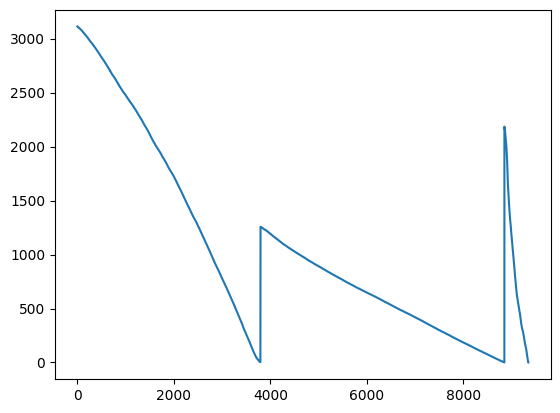

In [ ]:
plt.plot(processed_train_targets)

In [ ]:
processed_train_targets

array([3113., 3113., 3113., ...,    0.,    0.,    0.])

In [ ]:
processed_train_data

array([[[-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -0.99923401],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
        [-0.94285714, -0.99979581, -0.99999999, -0.99631676,
         -1.        , -0.99974467]],

       [[-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
  

In [ ]:
len(temp_train_data)

12447

In [ ]:
len(temp_train_targets)

12447

In [ ]:
temp_train_targets

[2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2188.0,
 2188.0,
 2188.0,
 2188.0,
 2188.0,
 2187.0,
 2187.0,
 2187.0,
 2187.0,
 2186.0,
 2186.0,
 2185.0,
 2185.0,
 2185.0,
 2185.0,
 2185.0,
 2184.0,
 2184.0,
 2184.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2181.0,
 2181.0,
 2181.0,
 2181.0,
 2180.0,
 2180.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2177.0,
 2177.0,
 2177.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2174.0,
 2174.0,
 2174.0,
 2174.0,
 2174.0,
 

In [ ]:
len(train_data['label'].where(train_data['specimen']==1).dropna())

94899

In [ ]:
temp_train_targets=list(temp_train_targets)


In [ ]:
temp_train_targets

[2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2191.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2190.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2189.0,
 2188.0,
 2188.0,
 2188.0,
 2188.0,
 2188.0,
 2187.0,
 2187.0,
 2187.0,
 2187.0,
 2186.0,
 2186.0,
 2185.0,
 2185.0,
 2185.0,
 2185.0,
 2185.0,
 2184.0,
 2184.0,
 2184.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2183.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2182.0,
 2181.0,
 2181.0,
 2181.0,
 2181.0,
 2180.0,
 2180.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2179.0,
 2177.0,
 2177.0,
 2177.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2176.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2175.0,
 2174.0,
 2174.0,
 2174.0,
 2174.0,
 2174.0,
 

In [ ]:
temp_train_data[350:420]

array([[3.100000e+01, 8.000000e+00, 3.054611e-01, 6.000000e-04,
        0.000000e+00, 3.000000e+00],
       [3.200000e+01, 8.000000e+02, 9.216714e+00, 6.000000e-04,
        1.400000e+02, 1.400000e+01],
       [3.100000e+01, 6.000000e+00, 1.100442e-01, 6.000000e-04,
        0.000000e+00, 3.000000e+00],
       [3.100000e+01, 2.800000e+01, 4.566555e-01, 6.000000e-04,
        0.000000e+00, 3.000000e+00],
       [3.200000e+01, 4.750000e+02, 5.565425e+00, 6.000000e-04,
        2.950000e+02, 1.300000e+01],
       [3.000000e+01, 1.000000e+00, 7.178010e-02, 6.000000e-04,
        0.000000e+00, 1.000000e+00],
       [3.100000e+01, 0.000000e+00, 0.000000e+00, 6.000000e-04,
        0.000000e+00, 2.000000e+00],
       [3.200000e+01, 4.400000e+01, 1.326210e+00, 6.000000e-04,
        2.000000e+01, 6.000000e+00],
       [2.900000e+01, 0.000000e+00, 0.000000e+00, 6.000000e-04,
        0.000000e+00, 1.000000e+00],
       [2.900000e+01, 0.000000e+00, 0.000000e+00, 6.000000e-04,
        0.000000e+00, 1.000

In [ ]:
processed_test_data

array([[[-0.91428571, -0.99962565, -0.99999998, -1.        ,
         -0.99983587, -0.99923401],
        [-0.88571429, -0.99656281, -0.99999994, -1.        ,
         -0.99983587, -0.99770203],
        [-0.88571429, -0.99914921, -0.99999997, -1.        ,
         -0.99844077, -0.99923401],
        [-0.94285714, -0.99931937, -0.99999999, -1.        ,
         -1.        , -0.99948934],
        [-0.94285714, -0.99996597, -1.        , -1.        ,
         -1.        , -0.99974467],
        [-0.8       , -0.99761779, -0.99999992, -1.        ,
         -0.99844077, -0.99668071],
        [-0.88571429, -0.99965968, -0.99999999, -1.        ,
         -0.99983587, -0.99872335],
        [-0.85714286, -0.99918324, -0.99999996, -1.        ,
         -0.99876903, -0.99770203],
        [-0.82857143, -0.99356804, -0.99999988, -1.        ,
         -0.99917935, -0.99617005],
        [-0.77142857, -0.99717538, -0.99999989, -1.        ,
         -0.99909729, -0.99617005],
        [-0.85714286, -0.99768

In [ ]:
true_rul

array([761, 315,   0])

In [ ]:
processed_train_targets

array([3113., 3113., 3113., ...,    0.,    0.,    0.])

In [ ]:
processed_train_data

array([[[-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -0.99923401],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
        [-0.94285714, -0.99979581, -0.99999999, -0.99631676,
         -1.        , -0.99974467]],

       [[-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-0.97142857, -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , -0.99631676,
         -1.        , -0.99974467],
  

In [ ]:
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul)

(233671, 50, 6)
(233671,)
(9, 50, 6)
[761 315   0]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(2627)

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]

    else:
        max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask

        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.3,
                                                                                                            shuffle=False)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (6542, 50, 6)
Processed validation data shape:  (2805, 50, 6)
Processed train targets shape:  (6542,)
Processed validation targets shape:  (2805,)


In [ ]:
processed_train_targets[10000]

2896.0

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(32, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(64, 5, activation = "relu"),
        layers.Conv1D(128, 3, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation = "relu"),
        layers.Dense(64, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam())
    return model

In [ ]:
def scheduler(epoch):
    if epoch < 10:
        return 0.005
    else:
        return 0.0001

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 20,
                    validation_data = (processed_val_data, processed_val_targets),

                    batch_size = 128, verbose = 2)

Epoch 1/20
52/52 - 3s - loss: 2205184.7500 - val_loss: 639612.5625 - 3s/epoch - 50ms/step
Epoch 2/20
52/52 - 0s - loss: 705792.5625 - val_loss: 1046199.0625 - 264ms/epoch - 5ms/step
Epoch 3/20
52/52 - 0s - loss: 681024.1875 - val_loss: 907551.8750 - 271ms/epoch - 5ms/step
Epoch 4/20
52/52 - 0s - loss: 683450.2500 - val_loss: 1071323.1250 - 262ms/epoch - 5ms/step
Epoch 5/20
52/52 - 0s - loss: 681937.5000 - val_loss: 943759.5000 - 271ms/epoch - 5ms/step
Epoch 6/20
52/52 - 0s - loss: 681742.9375 - val_loss: 982993.3750 - 277ms/epoch - 5ms/step
Epoch 7/20
52/52 - 0s - loss: 682019.6875 - val_loss: 966275.8125 - 293ms/epoch - 6ms/step
Epoch 8/20
52/52 - 0s - loss: 680950.3125 - val_loss: 1080574.8750 - 274ms/epoch - 5ms/step
Epoch 9/20
52/52 - 0s - loss: 681526.8750 - val_loss: 1161687.2500 - 282ms/epoch - 5ms/step
Epoch 10/20
52/52 - 0s - loss: 682721.1875 - val_loss: 1135745.6250 - 378ms/epoch - 7ms/step
Epoch 11/20
52/52 - 0s - loss: 680811.0625 - val_loss: 973266.8125 - 482ms/epoch - 9m

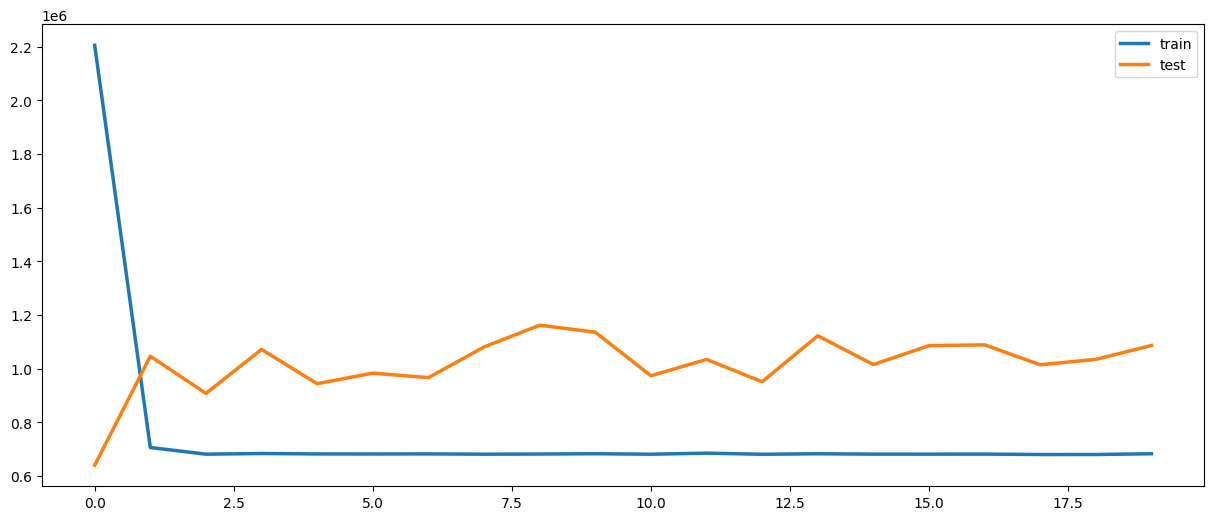

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [ ]:
processed_train_targets

array([3113., 3113., 3112., ...,  523.,  523.,  523.])

In [ ]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)

1/1 [==============================] - 0s 210ms/step


In [ ]:
rul_pred_scaled


array([1293.1605, 1296.2406, 1278.4022, 1285.4474, 1259.5436, 1293.6566,
       1344.0327, 1319.2026, 1349.467 , 1343.5472, 1346.3062, 1347.4852,
       1347.5657, 1345.6166, 1097.9287], dtype=float32)

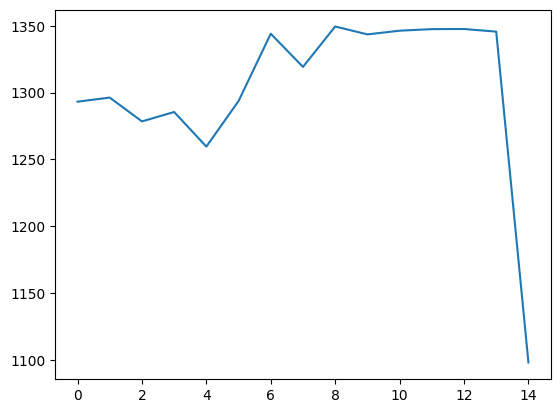

In [ ]:
plt.plot(rul_pred_scaled)

In [ ]:
preds_for_each_engine = np.split(rul_pred_scaled, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  997.3914178193522


In [ ]:
mean_pred_for_each_engine

[1282.5588623046874, 1329.9812500000003, 1296.9804687500002]

In [ ]:
b=list(mean_pred_for_each_engine)

In [ ]:
b.reverse()

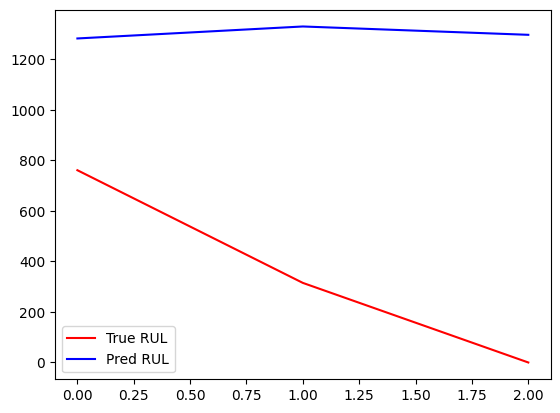

In [ ]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(mean_pred_for_each_engine, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

In [ ]:
processed_train_targets

array([1.        , 1.        , 1.        , ..., 0.09797623, 0.09797623,
       0.09797623])

In [ ]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

1/1 [==============================] - 0s 87ms/step
RMSE:  3155106.2276698714


In [ ]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

preds_for_each_engine = np.split(rul_pred_scaled, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

1/1 [==============================] - 0s 34ms/step
RMSE:  1062.002171058336


In [ ]:
rul_pred

array([  45264.215,   30824.146,   12120.07 , 1779770.   , 1785283.5  ,
       1804869.9  , 5039898.5  , 5104133.5  , 5346076.5  ], dtype=float32)

In [ ]:
rul_pred_scaled

array([  14.540383,    9.90175 ,    3.893373,  571.7218  ,  573.4929  ,
        579.7847  , 1618.9844  , 1639.6189  , 1717.339   ], dtype=float32)

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  1094.3147934311896


In [ ]:
b=list(preds_for_last_example)

In [ ]:
b.reverse()

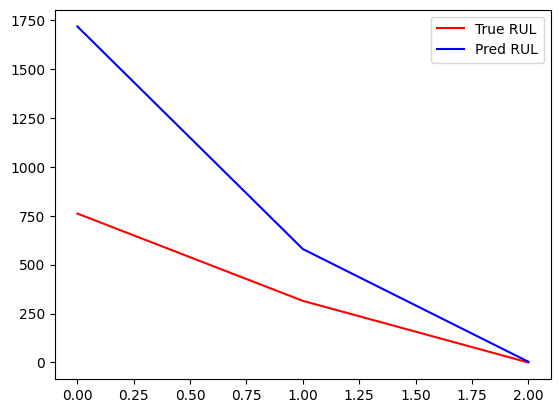

In [ ]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(b, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [ ]:
preds_for_last_example

array([ 0.2661909 ,  0.342589  , -0.01005176], dtype=float32)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, mask)).batch(128).prefetch(tf.data.AUTOTUNE)

NameError: name 'mask' is not defined

### How to scale the whole dataset?

In the previous cells, we showed the procedure to scale data enginewise. But for some applications, we may need to scale the full training and test dataset. This can be achieved as follows. In the cell below, we will use `StandardScaling` to scale the full training and test set.

In [ ]:
#train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD001.txt", sep= "\s+", header = None)
#test_data = pd.read_csv("/home/biswajit/data/cmapss_data/test_FD001.txt", sep = "\s+", header = None)
#true_rul = pd.read_csv("/home/biswajit/data/cmapss_data/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 1000
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 1
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [6,7]

train_data_first_column = train_data[0]
test_data_first_column = test_data1[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data1.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data separately as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training rul shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/biswajit/data/cmapss_data/test_FD001.txt'

Now we can use our favorite algorithm to train the model. If we want to change shape of training data, we can change `window_length`, and `shift` to get desired shape of input data. Similarly we can either use linear degradation model of RUL (by setting `early_rul = Null`) or use piecewise linear degradation model by using a suitable value of `early_rul`. If we to scale data differently, we can use a different scaler in place of `MinMaxScaler` or `StandardScaler`.

In other notebooks, we will only use the functions to preprocess data and then apply the algorithm. Other notebooks applying different techniques for RUL prediction can be found [here](https://biswajitsahoo1111.github.io/rul_codes_open/).